In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("linearRegression").getOrCreate()

In [3]:
from pyspark.ml.regression import LinearRegression

In [4]:
data = spark.read.csv('disnakertrans-od_17044_persentase_tingkat_pengangguran_terbuka__kabupatenkota_data.csv',inferSchema =True, header=True)

In [5]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- kode_provinsi: integer (nullable = true)
 |-- nama_provinsi: string (nullable = true)
 |-- kode_kabupaten_kota: integer (nullable = true)
 |-- nama_kabupaten_kota: string (nullable = true)
 |-- persentase_tingkat_pengangguran_terbuka: double (nullable = true)
 |-- satuan: string (nullable = true)
 |-- tahun: integer (nullable = true)



In [6]:
data.show()

+---+-------------+-------------+-------------------+--------------------+---------------------------------------+------+-----+
| id|kode_provinsi|nama_provinsi|kode_kabupaten_kota| nama_kabupaten_kota|persentase_tingkat_pengangguran_terbuka|satuan|tahun|
+---+-------------+-------------+-------------------+--------------------+---------------------------------------+------+-----+
|  1|           32|   JAWA BARAT|               3201|     KABUPATEN BOGOR|                                  14.26|PERSEN| 2007|
|  2|           32|   JAWA BARAT|               3202|  KABUPATEN SUKABUMI|                                  10.85|PERSEN| 2007|
|  3|           32|   JAWA BARAT|               3203|   KABUPATEN CIANJUR|                                  13.82|PERSEN| 2007|
|  4|           32|   JAWA BARAT|               3204|   KABUPATEN BANDUNG|                                  17.37|PERSEN| 2007|
|  5|           32|   JAWA BARAT|               3205|     KABUPATEN GARUT|                              

In [7]:
data.head(1)[0]

Row(id=1, kode_provinsi=32, nama_provinsi='JAWA BARAT', kode_kabupaten_kota=3201, nama_kabupaten_kota='KABUPATEN BOGOR', persentase_tingkat_pengangguran_terbuka=14.26, satuan='PERSEN', tahun=2007)

In [8]:
for item in data.head(1)[0]:
    print(item)

1
32
JAWA BARAT
3201
KABUPATEN BOGOR
14.26
PERSEN
2007


In [9]:
from pyspark.ml.linalg import Vectors

In [10]:
from pyspark.ml.feature import VectorAssembler

In [11]:
data.columns

['id',
 'kode_provinsi',
 'nama_provinsi',
 'kode_kabupaten_kota',
 'nama_kabupaten_kota',
 'persentase_tingkat_pengangguran_terbuka',
 'satuan',
 'tahun']

In [16]:
assembler = VectorAssembler(inputCols=['id',
 'kode_provinsi',
 
 'kode_kabupaten_kota',
 'persentase_tingkat_pengangguran_terbuka',
 'tahun'],outputCol= 'features')

In [17]:
output = assembler.transform(data)

In [18]:
output.head(1)

[Row(id=1, kode_provinsi=32, nama_provinsi='JAWA BARAT', kode_kabupaten_kota=3201, nama_kabupaten_kota='KABUPATEN BOGOR', persentase_tingkat_pengangguran_terbuka=14.26, satuan='PERSEN', tahun=2007, features=DenseVector([1.0, 32.0, 3201.0, 14.26, 2007.0]))]

In [20]:
final_data = output.select('features', 'persentase_tingkat_pengangguran_terbuka')

In [21]:
final_data.show()

+--------------------+---------------------------------------+
|            features|persentase_tingkat_pengangguran_terbuka|
+--------------------+---------------------------------------+
|[1.0,32.0,3201.0,...|                                  14.26|
|[2.0,32.0,3202.0,...|                                  10.85|
|[3.0,32.0,3203.0,...|                                  13.82|
|[4.0,32.0,3204.0,...|                                  17.37|
|[5.0,32.0,3205.0,...|                                  12.18|
|[6.0,32.0,3206.0,...|                                   8.48|
|[7.0,32.0,3207.0,...|                                   4.39|
|[8.0,32.0,3208.0,...|                                  10.56|
|[9.0,32.0,3209.0,...|                                  13.64|
|[10.0,32.0,3210.0...|                                   7.46|
|[11.0,32.0,3211.0...|                                   7.83|
|[12.0,32.0,3212.0...|                                  10.45|
|[13.0,32.0,3213.0...|                                 

In [22]:
train_data, test_data = final_data.randomSplit([0.7,0.3])

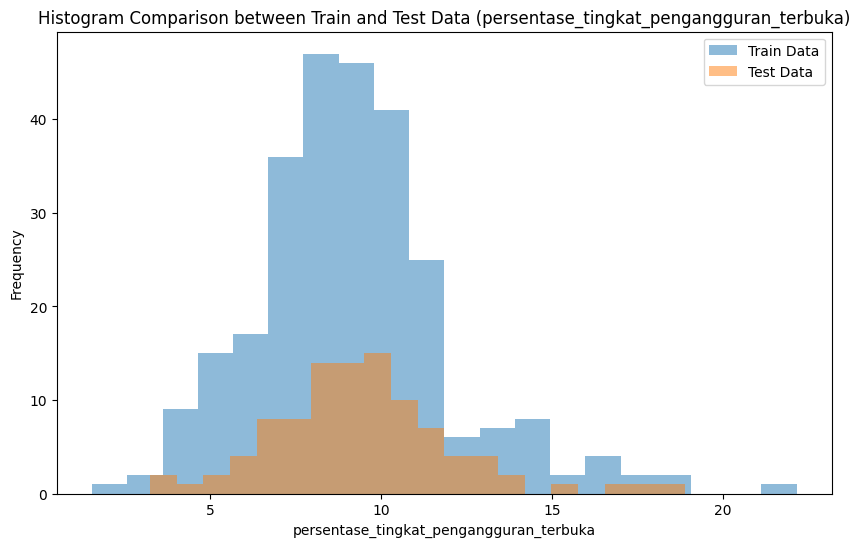

In [24]:
import matplotlib.pyplot as plt

# Ambil kolom yang ingin dibandingkan ('penutupan')
column_to_compare = 'persentase_tingkat_pengangguran_terbuka'

# Konversi DataFrame Spark ke Pandas untuk plotting
train_data_pd = train_data.select(column_to_compare).toPandas()
test_data_pd = test_data.select(column_to_compare).toPandas()

# Plot histogram
plt.figure(figsize=(10, 6))

plt.hist(train_data_pd[column_to_compare], bins=20, alpha=0.5, label='Train Data')
plt.hist(test_data_pd[column_to_compare], bins=20, alpha=0.5, label='Test Data')

plt.xlabel(column_to_compare)
plt.ylabel('Frequency')
plt.title(f'Histogram Comparison between Train and Test Data ({column_to_compare})')
plt.legend()

plt.show()



In [25]:
train_data.describe().show()

+-------+---------------------------------------+
|summary|persentase_tingkat_pengangguran_terbuka|
+-------+---------------------------------------+
|  count|                                    271|
|   mean|                      9.159114391143909|
| stddev|                     2.9060520422131795|
|    min|                                   1.56|
|    max|                                  22.15|
+-------+---------------------------------------+



In [27]:
lr = LinearRegression(labelCol="persentase_tingkat_pengangguran_terbuka")

In [28]:
lr_model = lr.fit(train_data)

In [29]:
# Mendapatkan koefisien dari model regresi
coefficients = lr_model.coefficients

# Menyusun koefisien dan nama variabel ke dalam dictionary
coef_dict = {'intercept': lr_model.intercept}
for i, coef in enumerate(coefficients):
    coef_dict[f'feature{i+1}'] = coef

# Tampilkan koefisien untuk setiap variabel
for variable, coef in coef_dict.items():
    print(f'{variable}: {coef}')


intercept: -6.95552187139314e-06
feature1: -2.6707347736627015e-10
feature2: 0.0
feature3: -9.85647481810166e-12
feature4: 1.000000000078536
feature5: 3.4919396948702375e-09


In [30]:
test_results = lr_model.evaluate(test_data)

In [31]:
test_results.residuals.show(n=1004)

+--------------------+
|           residuals|
+--------------------+
|-2.15168256545439...|
|-2.08322958883400...|
|-2.02647818525747...|
|-1.96666398721845...|
|-1.75038614713685...|
|-2.15494768696089...|
|-2.01244727549010...|
|-2.01067109628638...|
|-2.01643448605182...|
|-1.90508249175991...|
|-1.79509580533476...|
|-1.71027600970319...|
|-1.62755959820515...|
|-1.55900981013701...|
|-1.47822660778729...|
|-1.78472792100592...|
|-1.65180882305548...|
|-1.43937484153866...|
|-1.44529526124870...|
|-1.24516681410113...|
|-1.20140395409862...|
|-1.08538831256055...|
|-1.17780647457266...|
|-1.15309788384365...|
|-1.12995994783204...|
|-1.06923341292031...|
|-9.41454736391733...|
|-8.30525692663286...|
|-1.14225890968100...|
|-1.12650333505825...|
|-1.10148050680436...|
|-9.55288737003456...|
|-8.49700221294824...|
|-6.43711572934080...|
|-5.05953501317435...|
|-7.44659978124673...|
|-6.60058763202187E-9|
|-5.56747714597349...|
|-5.19267828735792...|
|-2.85350765238945...|
|-1.8907773

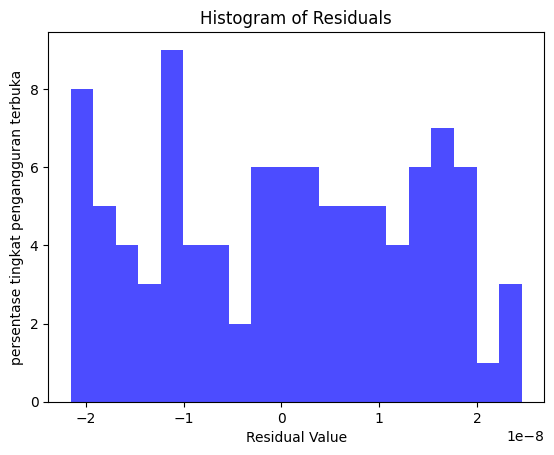

In [33]:
import matplotlib.pyplot as plt

# Dapatkan residual dari hasil evaluasi
residuals = test_results.residuals.toPandas()["residuals"]

# Buat histogram residual
plt.hist(residuals, bins=20, color='blue', alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('persentase tingkat pengangguran terbuka')
plt.title('Histogram of Residuals')
plt.show()



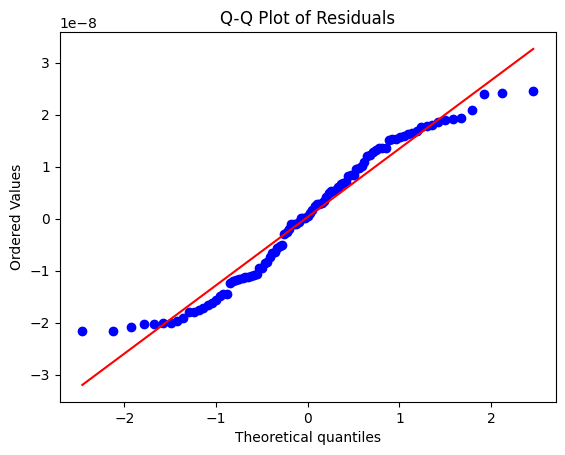

In [34]:
import scipy.stats as stats


# Create Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


In [35]:
test_results.rootMeanSquaredError

1.3125284090603527e-08

In [36]:
test_results.r2

1.0

In [37]:
final_data.describe().show()

+-------+---------------------------------------+
|summary|persentase_tingkat_pengangguran_terbuka|
+-------+---------------------------------------+
|  count|                                    370|
|   mean|                      9.247189189189188|
| stddev|                      2.838211428074365|
|    min|                                   1.56|
|    max|                                  22.15|
+-------+---------------------------------------+



In [ ]:
unlabeled_data = test_data.select('features')

In [ ]:
unlabeled_data.show()


In [ ]:
predictions = lr_model.transform(unlabeled_data)

In [ ]:
predictions.show()